라이브러리 로드

In [7]:
import sys,os
sys.path.append('/home/ahnsunghyun/pytorch/Ganomaly')
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from lib.networks import MyNetG

Tensor를 CV2 이미지로

In [9]:
# 텐서를 CV2 이미지로 변환
def tensor_to_cv_img(data):
    # get mean,std
    MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])

    # tensor to cv
    img = data # Tensor Shape. [C, H, W]
    img = img.detach().cpu().numpy() # tensor -> numpy
    img = np.transpose(img, (1, 2, 0)) # [C,H,W] -> [H,W,C]
    img = np.clip(255.0 * (img * STD + MEAN), 0, 255) # denomalize
    img = img.astype(np.uint8).copy() # np.float32 -> np.uint8

    return img

CV2 이미지를 PLT로 SHOW

In [18]:
# imshow function (cv2 image -> plt image -> plt.show)
# cv2 image를 plt image로 출력 
def imshow(in_img):
    out_img = cv2.cvtColor(in_img,cv2.COLOR_BGR2RGB) 
    plt.figure(figsize=(10,10))
    plt.imshow(out_img)
    plt.axis('off')
    plt.show()

UCSD PED1로 테스트한 산점도 확인 (skyblue:Anomaly, pink:Normal)

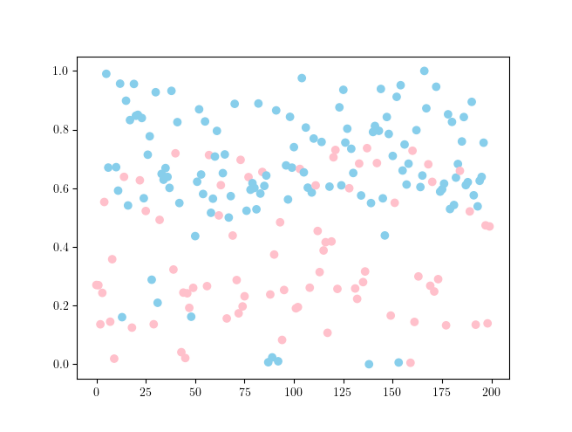

In [19]:
img=cv2.imread('../scatter.png',cv2.IMREAD_COLOR)
imshow(img)

시뮬레이션 데이터 확인

ucsd_simulation/video/ped1_24/129.tif


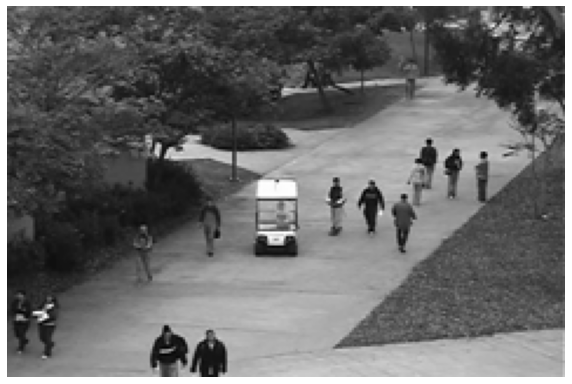

In [28]:
import random

dir=os.path.join('ucsd_simulation','video','ped1_24')
pathlist=os.listdir(dir)
r=random.randint(0,len(pathlist))
rpath=dir+'/'+pathlist[r]
print(rpath)
img=cv2.imread(rpath,cv2.IMREAD_COLOR)
imshow(img)

실험을 위한 데이터로더 생성

In [8]:
# dataloader['video']에서 가져온 data[0]은 배치 데이터, data[1]은 배치 타겟 
# 타겟은 class 디렉토리에 의해 자동 매핑됨
# 시뮬레이션을 할 때는 타겟을 따로 설정하지 않았음
'''
ucsd_simulation
├── video
│   ├── ped1_24
│   │   └── 0.png
│   │   └── 1.png
│   │   ...
│   │   └── n.png
'''
def make_loader(path):
    splits = ['video']
    shuffle = {'video':False}

    transform = transforms.Compose([transforms.Resize(64),
                                    transforms.CenterCrop(64),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ])

    dataset = {x: ImageFolder(os.path.join(path, x), transform) for x in splits}
    dataloader = {x: torch.utils.data.DataLoader(dataset=dataset[x],
                                                batch_size=64,
                                                shuffle=shuffle[x])
                    for x in splits}
    return dataloader

인퍼런스 (배치 사이즈:64)

In [11]:
with torch.no_grad():
    # make model
    netg=MyNetG()

    # get weight 
    path = "../output/{}/{}/train/weights/netG.pth".format('ganomaly','custom_ucsd')
    pretrained_dict = torch.load(path)['state_dict']

    # load weight
    try:
        netg.load_state_dict(pretrained_dict)
    except IOError:
        raise IOError("netG weights not found")
    print('Loaded weights.')

    # frame file path
    dir='./ucsd_simulation'

    # make dataloader
    dl=make_loader(dir)

    # inference
    batchsize=64
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    an_scores=torch.zeros(size=(len(dl['video'].dataset),), dtype=torch.float32, device=device)
    reals=[]
    fakes=[]
    for i, data in enumerate(dl['video'], 0):
        # data[0] is batch_tensors
        real=data[0]

        # inference
        fake, latent_i, latent_o = netg(real) 

        # save real and fake tensors
        for b in range(batchsize):
            if i*batchsize+b < 200:
                reals.append(real[b])
                fakes.append(fake[b])

        # get anomaly_scores
        error = torch.mean(torch.pow((latent_i-latent_o), 2), dim=1) 
        an_scores[i*batchsize : i*batchsize+error.size(0)] = error.reshape(error.size(0))

    # normalize
    an_scores = (an_scores - torch.min(an_scores)) / (torch.max(an_scores) - torch.min(an_scores))

print('frame length:',len(an_scores))
print('inference ok!')


Loaded weights.
frame length: 200
inference ok!


REAL/FAKE 프레임 비교 및 Anomaly 점수 확인

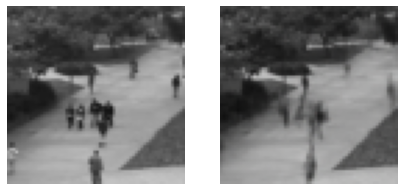

10) [Real/Fake] Anomaly Score: tensor(0.4209, device='cuda:0')


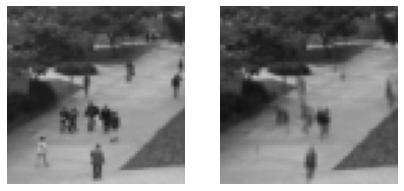

20) [Real/Fake] Anomaly Score: tensor(0.5313, device='cuda:0')


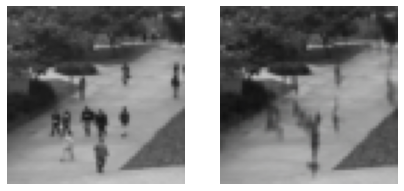

30) [Real/Fake] Anomaly Score: tensor(0.5586, device='cuda:0')


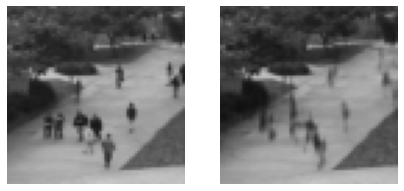

40) [Real/Fake] Anomaly Score: tensor(0.5595, device='cuda:0')


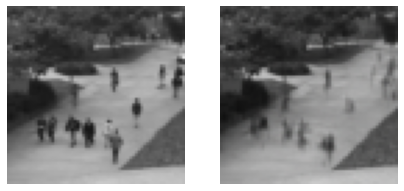

50) [Real/Fake] Anomaly Score: tensor(0.7020, device='cuda:0')


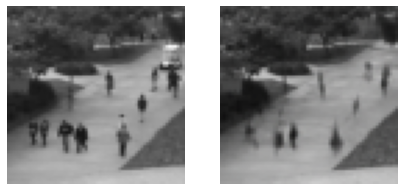

60) [Real/Fake] Anomaly Score: tensor(0.6270, device='cuda:0')


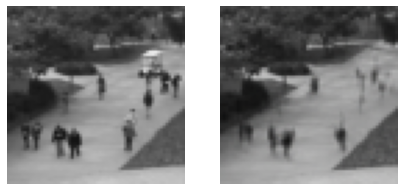

70) [Real/Fake] Anomaly Score: tensor(0.5288, device='cuda:0')


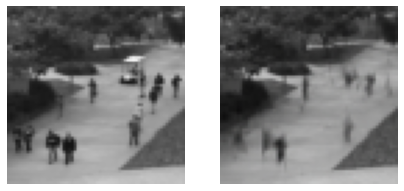

80) [Real/Fake] Anomaly Score: tensor(0.6128, device='cuda:0')


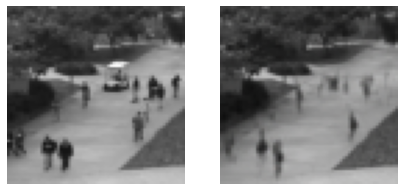

90) [Real/Fake] Anomaly Score: tensor(0.7154, device='cuda:0')


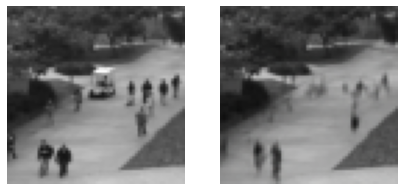

100) [Real/Fake] Anomaly Score: tensor(0.4552, device='cuda:0')


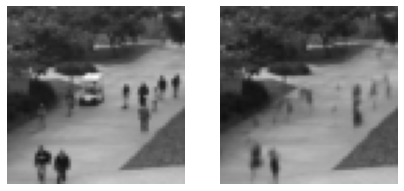

110) [Real/Fake] Anomaly Score: tensor(0.5806, device='cuda:0')


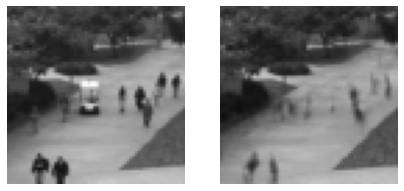

120) [Real/Fake] Anomaly Score: tensor(0.7691, device='cuda:0')


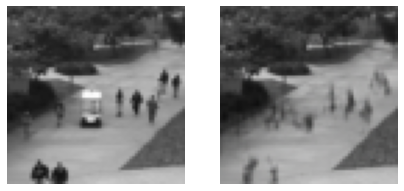

130) [Real/Fake] Anomaly Score: tensor(0.4753, device='cuda:0')


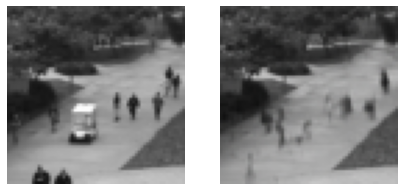

140) [Real/Fake] Anomaly Score: tensor(0.6195, device='cuda:0')


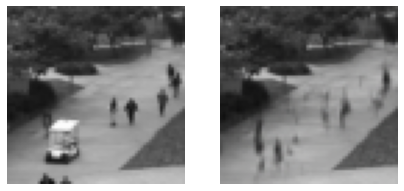

150) [Real/Fake] Anomaly Score: tensor(0.7738, device='cuda:0')


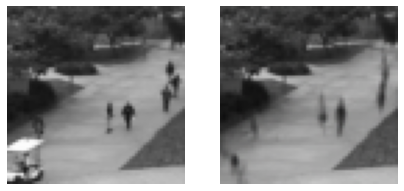

160) [Real/Fake] Anomaly Score: tensor(0.4455, device='cuda:0')


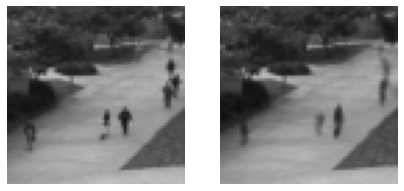

170) [Real/Fake] Anomaly Score: tensor(0.0005, device='cuda:0')


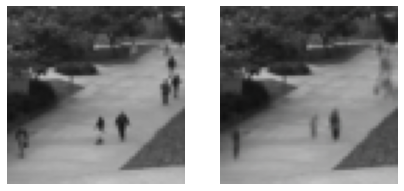

180) [Real/Fake] Anomaly Score: tensor(0.1280, device='cuda:0')


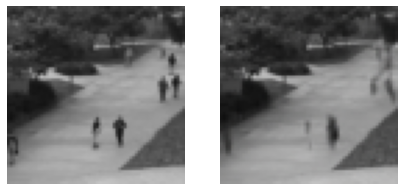

190) [Real/Fake] Anomaly Score: tensor(0.1721, device='cuda:0')


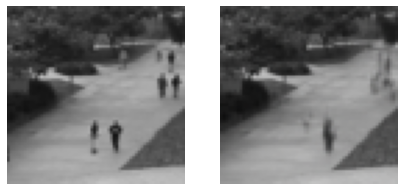

200) [Real/Fake] Anomaly Score: tensor(0.3286, device='cuda:0')


In [12]:
# show real and fake image and anomaly score
# len(reals) is as same as dataset size
for i in range(len(reals)):
    if (i+1)%10 ==0:
        f, a = plt.subplots(1,2,figsize=(7,7))
        a=a.ravel()
        # plt image setting
        for j,ax in enumerate(a):
            if j==0:
                real=tensor_to_cv_img(reals[i])
                ax.imshow(real)
            else:
                fake=tensor_to_cv_img(fakes[i])
                ax.imshow(fake)
            ax.axis('off')
        plt.show()
        print(str(i+1)+') [Real/Fake] Anomaly Score:',an_scores[i])

시뮬레이션을 위한 세팅 (프레임 파일명 저장)

In [13]:
# simulation prepare
# frame_name sorting
frame_names=[]
for f in os.listdir(os.path.join(dir,'video/ped1_24')):
    frame_names.append(f[:-4])
frame_names.sort()

# save frame_path using frame_names 
frame_paths=[]
for i in range(len(frame_names)):
    frame_paths.append(os.path.join(dir,'video/ped1_24',frame_names[i]+'.tif'))

# cv2 text font and color
red= (0, 0, 255)
font =  cv2.FONT_HERSHEY_PLAIN

시뮬레이션 (threshold=0.5)

In [15]:
# simulation start
anomaly=False
for i,fpath in enumerate(frame_paths):
    # check
    if an_scores[i] >= 0.5:
        anomaly=True
        print(i+1,') an_score:',an_scores[i],'(Anomaly) path:[',fpath,']')
    else:
        anomaly=False
        print(i+1,') an_score:',an_scores[i],'(Normal) path:[',fpath,']')

    # show
    img = cv2.imread(fpath,cv2.IMREAD_COLOR)
    if anomaly:  # Anomaly => putText
        img = cv2.putText(img, "Anomaly Frame", (100, 140), font, 2, red, 1, cv2.LINE_AA)
    cv2.imshow('ucsd ped1_24' , img)
    if cv2.waitKey(30) == 27: # esc => close
        break

    # save
    cv2.imwrite('./output/ped1_24/{}.tif'.format(i+1),img)
    
cv2.destroyAllWindows()
print('save ok!')

1 ) an_score: tensor(0.2376, device='cuda:0') (Normal) path:[ ./ucsd_simulation/video/ped1_24/001.tif ]
2 ) an_score: tensor(0.2458, device='cuda:0') (Normal) path:[ ./ucsd_simulation/video/ped1_24/002.tif ]
3 ) an_score: tensor(0.2595, device='cuda:0') (Normal) path:[ ./ucsd_simulation/video/ped1_24/003.tif ]
4 ) an_score: tensor(0.2398, device='cuda:0') (Normal) path:[ ./ucsd_simulation/video/ped1_24/004.tif ]
5 ) an_score: tensor(0.2506, device='cuda:0') (Normal) path:[ ./ucsd_simulation/video/ped1_24/005.tif ]
6 ) an_score: tensor(0.2760, device='cuda:0') (Normal) path:[ ./ucsd_simulation/video/ped1_24/006.tif ]
7 ) an_score: tensor(0.2832, device='cuda:0') (Normal) path:[ ./ucsd_simulation/video/ped1_24/007.tif ]
8 ) an_score: tensor(0.3269, device='cuda:0') (Normal) path:[ ./ucsd_simulation/video/ped1_24/008.tif ]
9 ) an_score: tensor(0.3753, device='cuda:0') (Normal) path:[ ./ucsd_simulation/video/ped1_24/009.tif ]
10 ) an_score: tensor(0.4209, device='cuda:0') (Normal) path:[ .